In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [33]:
dt=pd.read_csv('ai_job_dataset.csv')

In [34]:
dt.head()

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [35]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

In [36]:
dt.drop(columns=['job_id','salary_currency'],inplace=True)

In [37]:
dt.drop(columns=['company_name','employment_type','remote_ratio','job_title','industry','job_description_length','required_skills'],inplace=True)

In [38]:
dt['posting_date'] = pd.to_datetime(dt['posting_date'])

In [39]:
dt['application_deadline'] = pd.to_datetime(dt['application_deadline'])

In [40]:
dt['App_time']=dt['application_deadline']-dt['posting_date']

In [41]:
dt.drop(columns=['posting_date','application_deadline'],inplace=True)

In [42]:
dt_numeric = dt.select_dtypes(include='number')
dt_numeric.corr()


,salary_usd,years_experience,benefits_score,App_time
salary_usd,1.000000,0.737556,0.000985,0.012784
years_experience,0.737556,1.000000,-0.007275,0.001202
benefits_score,0.000985,-0.007275,1.000000,0.006461
App_time,0.012784,0.001202,0.006461,1.000000


In [43]:
dt['education_required'].value_counts()

,count
education_required,
Bachelor,3789
Associate,3785
Master,3748
PhD,3678


In [44]:
dt['experience_level'].value_counts()

,count
experience_level,
MI,3781
EX,3760
SE,3741
EN,3718


In [45]:
dt['company_size'].value_counts()

,count
company_size,
S,5007
L,4998
M,4995


In [46]:
dt['company_location'].value_counts()

,count
company_location,
Germany,814
Denmark,778
Canada,769
France,769
Austria,765
Singapore,764
China,763
India,754
Sweden,752


In [47]:
dt['employee_residence'].value_counts()

,count
employee_residence,
Sweden,790
France,781
Denmark,777
Austria,776
India,772
Germany,769
South Korea,763
Canada,762
China,761


In [48]:
dp = dt[['employee_residence', 'company_location']].copy()

all_locations = pd.unique(dp[['employee_residence', 'company_location']].values.ravel())

for loc in all_locations:
    dp[f'location_{loc}'] = (
        (dp['employee_residence'] == loc).astype(int) +
        (dp['company_location'] == loc).astype(int)
    )

dp = dp.drop(['employee_residence', 'company_location'], axis=1)

In [49]:
dt = pd.concat([dt, dp], axis=1)

In [50]:
dt = dt.drop(['employee_residence', 'company_location'], axis=1)

In [51]:
Oe = OrdinalEncoder(categories=[['EN', 'MI', 'SE', 'EX']])
dt['experience_level'] = Oe.fit_transform(dt[['experience_level']])

In [52]:
Oe = OrdinalEncoder(categories=[['S','M','L']])
dt['company_size'] = Oe.fit_transform(dt[['company_size']])

In [53]:
Oe = OrdinalEncoder(categories=[['Associate', 'Bachelor', 'Master', 'PhD']])
dt['education_required'] = Oe.fit_transform(dt[['education_required']])

In [54]:
dt['App_time']=dt['App_time'].astype(int)

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(dt.drop('salary_usd', axis=1), dt['salary_usd'], test_size=0.2, random_state=42)

In [56]:
X_train.head()

,experience_level,company_size,education_required,years_experience,benefits_score,App_time,location_China,location_Ireland,location_Canada,location_South Korea,...,location_Austria,location_Sweden,location_Norway,location_Israel,location_Netherlands,location_United States,location_Australia,location_Denmark,location_Finland,location_Japan
9839,1.0,2.0,1.0,2,6.9,6307200000000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9680,2.0,0.0,2.0,5,6.3,4924800000000000,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
7093,0.0,1.0,2.0,0,9.7,2073600000000000,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
11293,2.0,2.0,1.0,5,5.4,2764800000000000,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
820,3.0,1.0,0.0,17,7.8,2592000000000000,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [57]:
# plt.figure(figsize=(14,4))
# plt.subplot(121)
# sns.distplot(X_train['years_experience'])
# plt.show()

In [58]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
X_train['years_experience'] = pt.fit_transform(X_train[['years_experience']])
X_test['years_experience'] = pt.transform(X_test[['years_experience']])

In [59]:
# plt.figure(figsize=(14,4))
# plt.subplot(121)
# sns.distplot(X_train['years_experience'])
# plt.show()

In [60]:
SS=StandardScaler()
X_train=SS.fit_transform(X_train)
X_test=SS.transform(X_test)

/tmp/ipython-input-61-2163986655.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train)


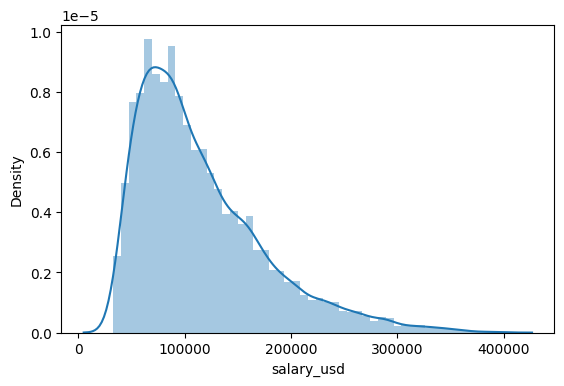

In [61]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(Y_train)
plt.show()

In [62]:
FT=FunctionTransformer(func=np.log1p)
Y_train=FT.fit_transform(Y_train)
Y_test=FT.transform(Y_test)

/tmp/ipython-input-63-2163986655.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train)


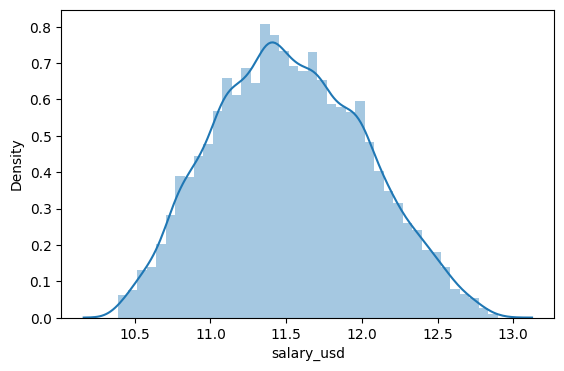

In [63]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(Y_train)
plt.show()

In [64]:
Xg=XGBRegressor()
Xg.fit(X_train,Y_train)
Y_pred1=Xg.predict(X_test)

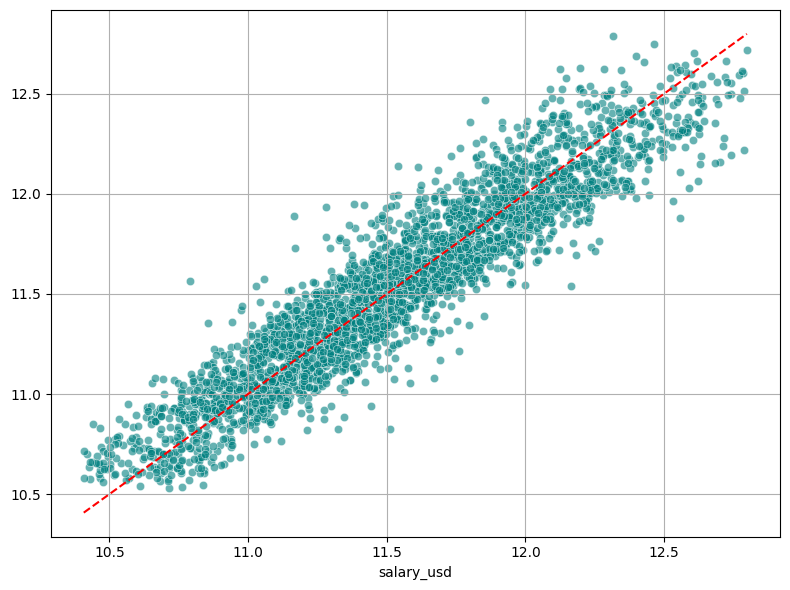

In [65]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=Y_pred1, alpha=0.6, color='teal')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, Y_pred1)
print("R² Score:", r2*100)

R² Score: 87.13120110103642


In [67]:
RF=RandomForestRegressor()
RF.fit(X_train,Y_train)
Y_pred2=RF.predict(X_test)

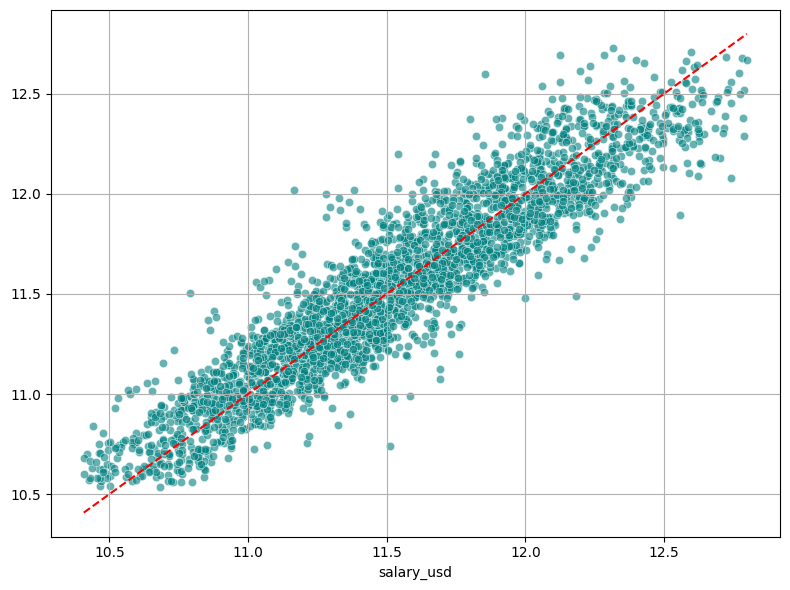

In [68]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=Y_pred2, alpha=0.6, color='teal')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
r2 = r2_score(Y_test, Y_pred2)
print("R² Score:", r2*100)

R² Score: 86.2287226391369


In [70]:
Svr=SVR(kernel='linear', C=10, epsilon=0.2)
Svr.fit(X_train,Y_train)
Y_pred3=Svr.predict(X_test)

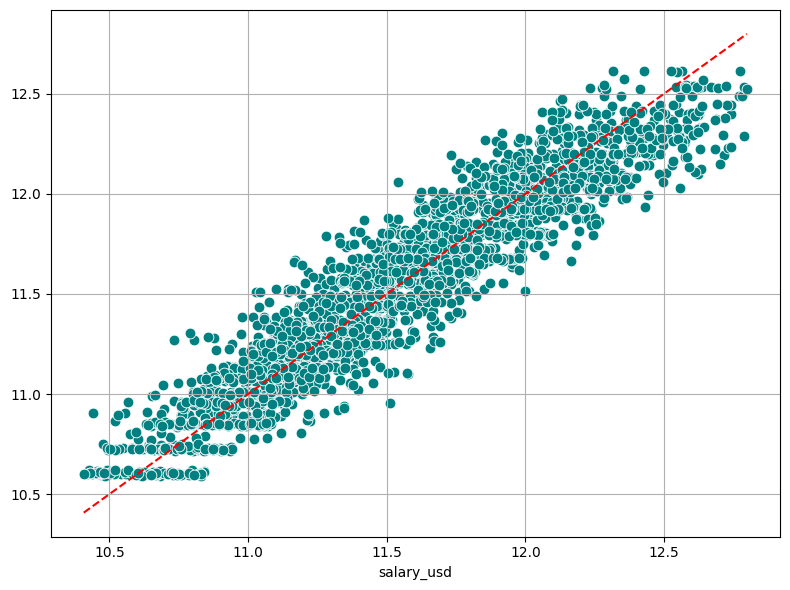

In [71]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=Y_pred3, color='teal', s=60)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r')
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
r2 = r2_score(Y_test, Y_pred3)
print("R² Score:", r2*100)

R² Score: 88.53046940351543
